### Pycrash - Impact Momentum Validation

In [1]:
# %% allow reloading of modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("D:\\OneDrive\\pycrash")
#sys.path.append("/home/joemcormier/pycrash/")
#sys.path.insert(0,'/home/jmc/Documents/pycrash')

In [3]:
from pycrash.project import Project, project_info, load_project
from pycrash.vehicle import Vehicle
from pycrash.kinematics import SingleMotion
from pycrash.kinematicstwo import KinematicsTwo
from pycrash.model_calcs.carpenter_momentum import IMPC
from pycrash.model_calcs.position_data import position_data_static
from pycrash.visualization.initial_positions import initial_position
from pycrash.visualization.kinematics_compare import compare_kinematics
from pycrash.visualization.model_interval_two_vehicles import plot_motion_interval
from pycrash.visualization.model_interval import plot_motion_interval as single_interval
from src.vehicle_data_collection import vehicle_data
from src.test_inputs_rose import test_data

Current values for defined constants:
maximum available friction (mu_max) = 0.76
time step for vehicle motion (dt) = 0.01 s
No Environment File Provided
No Environment File Provided


In [4]:
import pandas as pd
import numpy as np
import math
from scipy import integrate
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Load Project Datafile that was created when project was instantiated
- the project object contains information needed to run other parts of Pycrash

#### Get project information - used to import project object

In [6]:
project_info('validation impact momentum')

This saved project contains:
Object of type "project" with name "validation impact momentum"
list objects in this order for loading project: ['validation impact momentum']
Example: project_name, veh1, veh2 = load_project('project_name')


#### Load project and print contents

In [7]:
proj = load_project('validation impact momentum')
proj.show()

--------------------------  ------------------------  -----------  ---------------  -------------------------------------------------
Project                     Description               Impact Type  Simulation Type  Note
validation impact momentum  validate momentum models  IMPC         MV               validate impact models using various data sources
--------------------------  ------------------------  -----------  ---------------  -------------------------------------------------


### Load Vehicles
- vehicle data is stored in a seperate module
- this can be expanded upon as you use more vehicles in Pycrash
- vehicles depend on test

In [5]:
test_list = ['4363', '4364', '4438', '4474']
test_do = test_list[3]

In [6]:
if test_do == '4363':
    v1_inputs = vehicle_data['HondaAccord']
    veh1 = Vehicle('Accord', v1_inputs)
    veh1.striking = True # set to struck vehicle
    
    blazer_inputs = vehicle_data['ChevyBlazer']
    veh2 = Vehicle('Blazer', blazer_inputs)
    veh2.striking = False  # set to striking vehicle
elif test_do == '4364':
    v1_inputs = vehicle_data['HondaAccord']
    veh1 = Vehicle('Accord', v1_inputs)
    veh1.striking = True # set to struck vehicle
    
    v2_inputs = vehicle_data['ChevyTrailblazer']
    veh2 = Vehicle('Trailblazer', v2_inputs)
    veh2.striking = False  # set to striking vehicle
elif test_do == '4438':
    v1_inputs = vehicle_data['HondaAccord4438']
    veh1 = Vehicle('Accord', v1_inputs)
    veh1.striking = True # set to struck vehicle
    
    v2_inputs = vehicle_data['MitsubishiMontero']
    veh2 = Vehicle('Montero', v2_inputs)
    veh2.striking = False  # set to striking vehicle
elif test_do == '4474':
    v1_inputs = vehicle_data['HondaAccord4438']
    veh1 = Vehicle('Accord', v1_inputs)
    veh1.striking = True # set to struck vehicle
    
    v2_inputs = vehicle_data['MitsubishiMontero1999']
    veh2 = Vehicle('Montero', v2_inputs)
    veh2.striking = False  # set to striking vehicle

Vehicle inputs for Accord applied succesfully
Vehicle inputs for Montero applied succesfully


#### Load Test Inputs

In [7]:
inputs = test_data[test_do]
print(inputs)

{'v1_cg_ic': 2.9, 'v1_theta_cg_ic': 34.7, 'v1_head_angle': 180, 'v1_vx': 35, 'v2_cg_ic': 5.5, 'v2_theta_cg_ic': 15.2, 'v2_head_angle': 31.6, 'v2_vx': 35, 'impact_norm_deg': 51.8, 'cor': 0.15, 'critical_ir': -0.4, 'impulse_ratio': 1, 'v1_domega': 40, 'v1_dv': 40.5, 'v2_domega': 194, 'v2_dv': 28.7}


In [8]:
# get initial positions
# ---------- Vehicle 1 -------------#
veh1.head_angle = -1 * inputs['v1_head_angle']
veh1_dx = np.cos(-1 * inputs['v1_theta_cg_ic'] * np.pi / 180) * inputs['v1_cg_ic']
veh1_dy = np.sin(-1 * inputs['v1_theta_cg_ic'] * np.pi / 180) * inputs['v1_cg_ic']

v1_hangle_rad = veh1.head_angle * np.pi / 180
veh1.init_x_pos = -1 * (veh1_dx * np.cos(v1_hangle_rad) - veh1_dy * np.sin(v1_hangle_rad))
veh1.init_y_pos = -1 * (veh1_dx * np.sin(v1_hangle_rad) + veh1_dy * np.cos(v1_hangle_rad))

# impact point in vehicle 1 reference frame
veh1.pimpact_x = veh1_dx
veh1.pimpact_y = veh1_dy

# angle of normal impact vector
veh1.impact_norm_rad = -1 * inputs['impact_norm_deg'] * np.pi / 180

# ---------- Vehicle 2 -------------#
veh2.head_angle = -1 * inputs['v2_head_angle']
veh2_dx = np.cos(-1 * inputs['v2_theta_cg_ic'] * np.pi / 180) * inputs['v2_cg_ic']
veh2_dy = np.sin(-1 * inputs['v2_theta_cg_ic'] * np.pi / 180) * inputs['v2_cg_ic']

v2_hangle_rad = veh2.head_angle * np.pi / 180
veh2.init_x_pos = -1 * (veh2_dx * np.cos(v2_hangle_rad) - veh2_dy * np.sin(v2_hangle_rad))
veh2.init_y_pos = -1 * (veh2_dx * np.sin(v2_hangle_rad) + veh2_dy * np.cos(v2_hangle_rad))

### Plot Initial Positions

In [9]:
initial_position(position_data_static([veh1, veh2]))

### Create Momentum Simulation

In [10]:
# inputs for simulation
veh1.vx_initial = inputs['v1_vx']
veh2.vx_initial = inputs['v2_vx']

sim_inputs = {'cor': inputs['cor'],
             'cof': inputs['critical_ir'],
             'impact_norm_deg': -1*inputs['impact_norm_deg']}

In [11]:
name = test_do
run = IMPC(name, veh1, veh2, sim_inputs)

theta c: -141.80 [deg]
Sliding Condition
Compression
Forward Slide
Impact Energy: {'t_effects_dis': 65581.66927617385, 'n_effects_dis': 191962.6094958326, 'tn_total_dis': 257544.27877200645}


In [12]:
print(f"|--- Results for Simulation of Test: {test_do} --------|")
print("")
print(f"------- Results for Striking Vehicle: {veh1.name} -----")
print(f"Pycrash (Carpenter) delta-V for {veh1.name}: {run.v1_result['dv']:0.2f} mph")
print(f"Kineticorp (Brach) delta-V for {veh1.name}: {inputs['v1_dv']:0.2f} mph")
print("")
print(f"Pycrash (Carpenter) omega for {veh1.name}: {run.v1_result['oz_deg']:0.2f} deg/s")
print(f"Kineticorp (Brach) omega for {veh1.name}: {inputs['v1_domega']:0.2f} deg/s")
print("")
print(f"-------- Results for Struck Vehicle: {veh2.name} ------")
print(f"Pycrash (Carpenter) delta-V for {veh2.name}: {run.v2_result['dv']:0.2f} mph")
print(f"Kineticorp (Brach) delta-V for {veh2.name}: {inputs['v2_dv']:0.2f} mph")
print("")
print(f"Pycrash (Carpenter) omega for {veh2.name}: {run.v2_result['oz_deg']:0.2f} deg/s")
print(f"Kineticorp (Brach) omega for {veh2.name}: {inputs['v2_domega']:0.2f} deg/s")

|--- Results for Simulation of Test: 4474 --------|

------- Results for Striking Vehicle: Accord -----
Pycrash (Carpenter) delta-V for Accord: 40.43 mph
Kineticorp (Brach) delta-V for Accord: 40.50 mph

Pycrash (Carpenter) omega for Accord: -40.12 deg/s
Kineticorp (Brach) omega for Accord: 40.00 deg/s

-------- Results for Struck Vehicle: Montero ------
Pycrash (Carpenter) delta-V for Montero: 28.70 mph
Kineticorp (Brach) delta-V for Montero: 28.70 mph

Pycrash (Carpenter) omega for Montero: -193.66 deg/s
Kineticorp (Brach) omega for Montero: 194.00 deg/s


### Simulate Vehicle Motion Post-Impact

#### Create vehicle inputs - determines simulation duration

In [13]:
end_time = 2
t = np.arange(0, end_time + 0.01, 0.01).tolist()
throttle = [0] * len(t)                      
brake = [0] * len(t)              
steer = [0] * len(t)
driver_input_dict = {'t':t, 'throttle':throttle, 'brake':brake, 'steer':steer}
driver_input_df = pd.DataFrame.from_dict(driver_input_dict)
veh1.fwd = 1
veh2.fwd = 1
veh1.time_inputs(t, throttle, brake, steer)
veh2.time_inputs(t, throttle, brake, steer)
veh1.hcg = 1
veh2.hcg = 1
veh1.vx_initial = run.v1_result['vx']
veh1.vy_initial = run.v1_result['vy']
veh1.omega_z = run.v1_result['oz_deg']
veh2.vx_initial = run.v2_result['vx']
veh2.vy_initial = run.v2_result['vy']
veh2.omega_z = run.v2_result['oz_deg']

Driver inputs applied to Accord
Driver inputs applied to Montero


#### Run Simulation

In [14]:
run1 = SingleMotion('Veh1', veh1)
run2 = SingleMotion('Veh2', veh2)

Maximum allowable friction: 0.76
Time step for vehicle motion (s) : 0.01
Maximum tire slip angle (deg): 10.00
Driver input for Accord of shape = (201, 4)
Vehicle motion will be simulated for 2.0 seconds
Maximum allowable friction: 0.76
Time step for vehicle motion (s) : 0.01
Maximum tire slip angle (deg): 10.00
Driver input for Montero of shape = (201, 4)
Vehicle motion will be simulated for 2.0 seconds


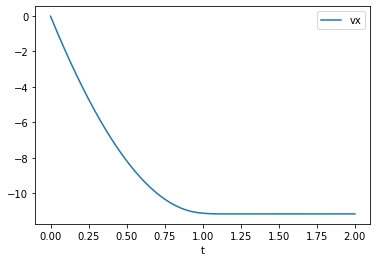

In [15]:
run1.veh.model.plot(x='t', y='vx')

In [20]:
plot_motion_interval([run1.veh, run2.veh], num_itter = 3)

In [43]:
single_interval(run1.veh, num_itter = 3)

In [39]:
len(run1.veh.model)

21

In [54]:
compare_kinematics(run1.veh.model, run1.veh.model, 'Veh1', 'Veh2')

AttributeError: 'DataFrame' object has no attribute 'phi_deg'